- Preparing
- Setup environment
- Prepare dataset
- Configure model
- Train model
- Evaluate model
- Inference and visualization
- Finish task

In [ ]:
# Check the available GPU
!nvidia-smi

Wed Oct 29 18:52:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Get the current working directory
import os
HOME = os.getcwd()
print(HOME)

/content


By default Google CoLab already has PyTorch installed, this is just showing that the depoendenceies are already installed

In [ ]:
# List installed torch packages to confirm installation
!pip list | grep torch

torch                                    2.8.0+cu126
torchao                                  0.10.0
torchaudio                               2.8.0+cu126
torchdata                                0.11.0
torchsummary                             1.5.1
torchtune                                0.6.1
torchvision                              0.23.0+cu126


In [ ]:
# Install ultralytics and roboflow libraries
%pip install ultralytics roboflow

# Import ultralytics and run checks to verify the environment
import ultralytics
ultralytics.checks()

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.8/112.6 GB disk)


In [ ]:
# Create a directory for datasets and change the current directory to it
!mkdir {HOME}/datasets
%cd {HOME}/datasets

# Retrieve Roboflow API key from Colab userdata and initialize Roboflow
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# Download the specified project version from Roboflow in yolov11 format
project = rf.workspace("joseph-nelson").project("bccd")
version = project.version(4)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BCCD-4 in yolov11:: 100%|██████████| 1760/1760 [00:00<00:00, 5797.76it/s]


In [ ]:
# Train the YOLOv11 model
# Ensure the data.yaml file is correctly configured for your dataset
# task=detect: specifies the task as object detection
# mode=train: sets the mode to training
# model=yolo11n.pt: specifies the pretrained model to use
# data=/content/datasets/BCCD-4/data.yaml: provides the path to the dataset configuration file
# epochs=10: sets the number of training epochs
!yolo task=detect mode=train model=yolo11n.pt data={HOME}/datasets/BCCD-4/data.yaml epochs=10

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/BCCD-4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

In [ ]:
# List the contents of the training run directory to check for output files
!ls {HOME}/datasets/runs/detect/train/

args.yaml			 labels.jpg		val_batch0_pred.jpg
BoxF1_curve.png			 results.csv		val_batch1_labels.jpg
BoxP_curve.png			 results.png		val_batch1_pred.jpg
BoxPR_curve.png			 train_batch0.jpg	val_batch2_labels.jpg
BoxR_curve.png			 train_batch1.jpg	val_batch2_pred.jpg
confusion_matrix_normalized.png  train_batch2.jpg	weights
confusion_matrix.png		 val_batch0_labels.jpg


In [ ]:
# Validate the trained model
# task=detect: specifies the task as object detection
# mode=val: sets the mode to validation
# model=/content/datasets/runs/detect/train/weights/best.pt: specifies the path to the trained model weights
# data=/content/datasets/BCCD-4/data.yaml: provides the path to the dataset configuration file
!yolo task=detect mode=val model={HOME}/datasets/runs/detect/train/weights/best.pt data={HOME}/datasets/BCCD-4/data.yaml

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 800.9±215.9 MB/s, size: 12.9 KB)
val: Scanning /content/datasets/BCCD-4/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 73/73 1.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.7it/s 2.9s
                   all         73        967      0.846      0.926      0.929      0.651
             Platelets         42         76      0.812      0.907      0.911      0.503
                   RBC         72        819      0.761      0.871      0.891      0.646
                   WBC         71         72      0.966          1      0.986      0.803
Speed: 5.6ms preprocess, 5.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /content/datasets/runs/detect/val
💡

In [ ]:
from IPython.display import Image as IPyImage

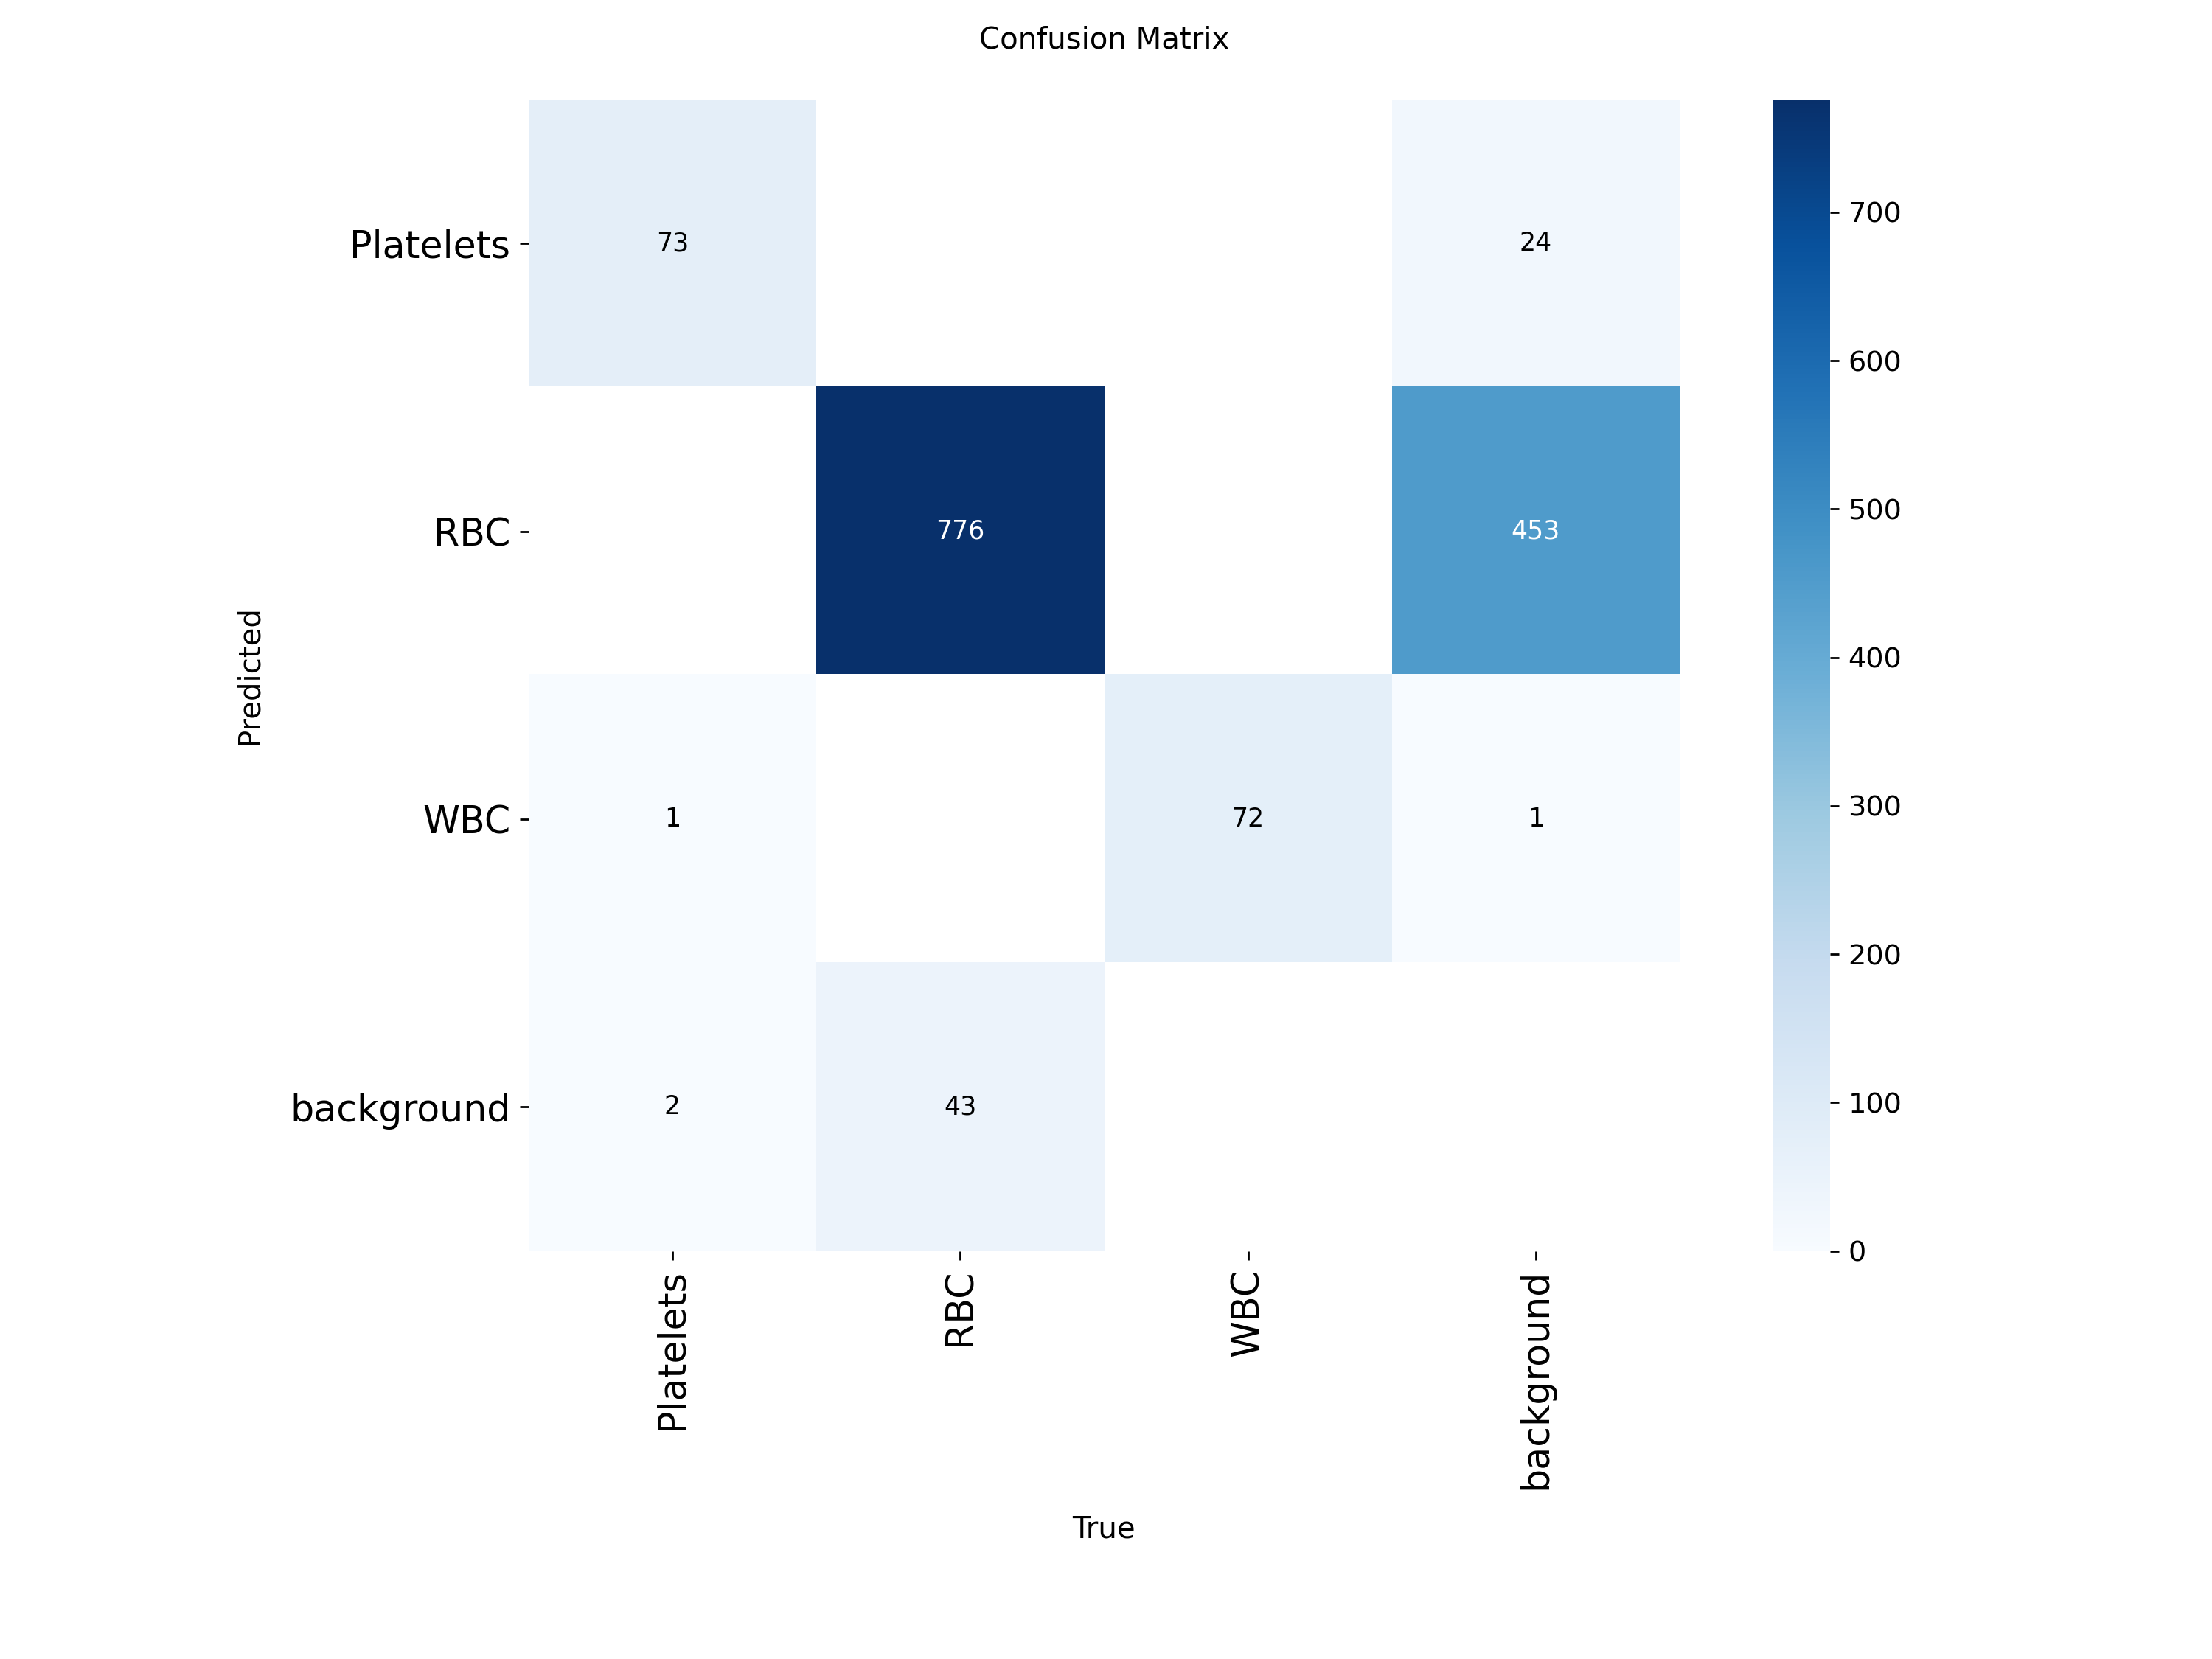

In [ ]:
IPyImage(filename=f'{HOME}/datasets/runs/detect/train/confusion_matrix.png', width=600)

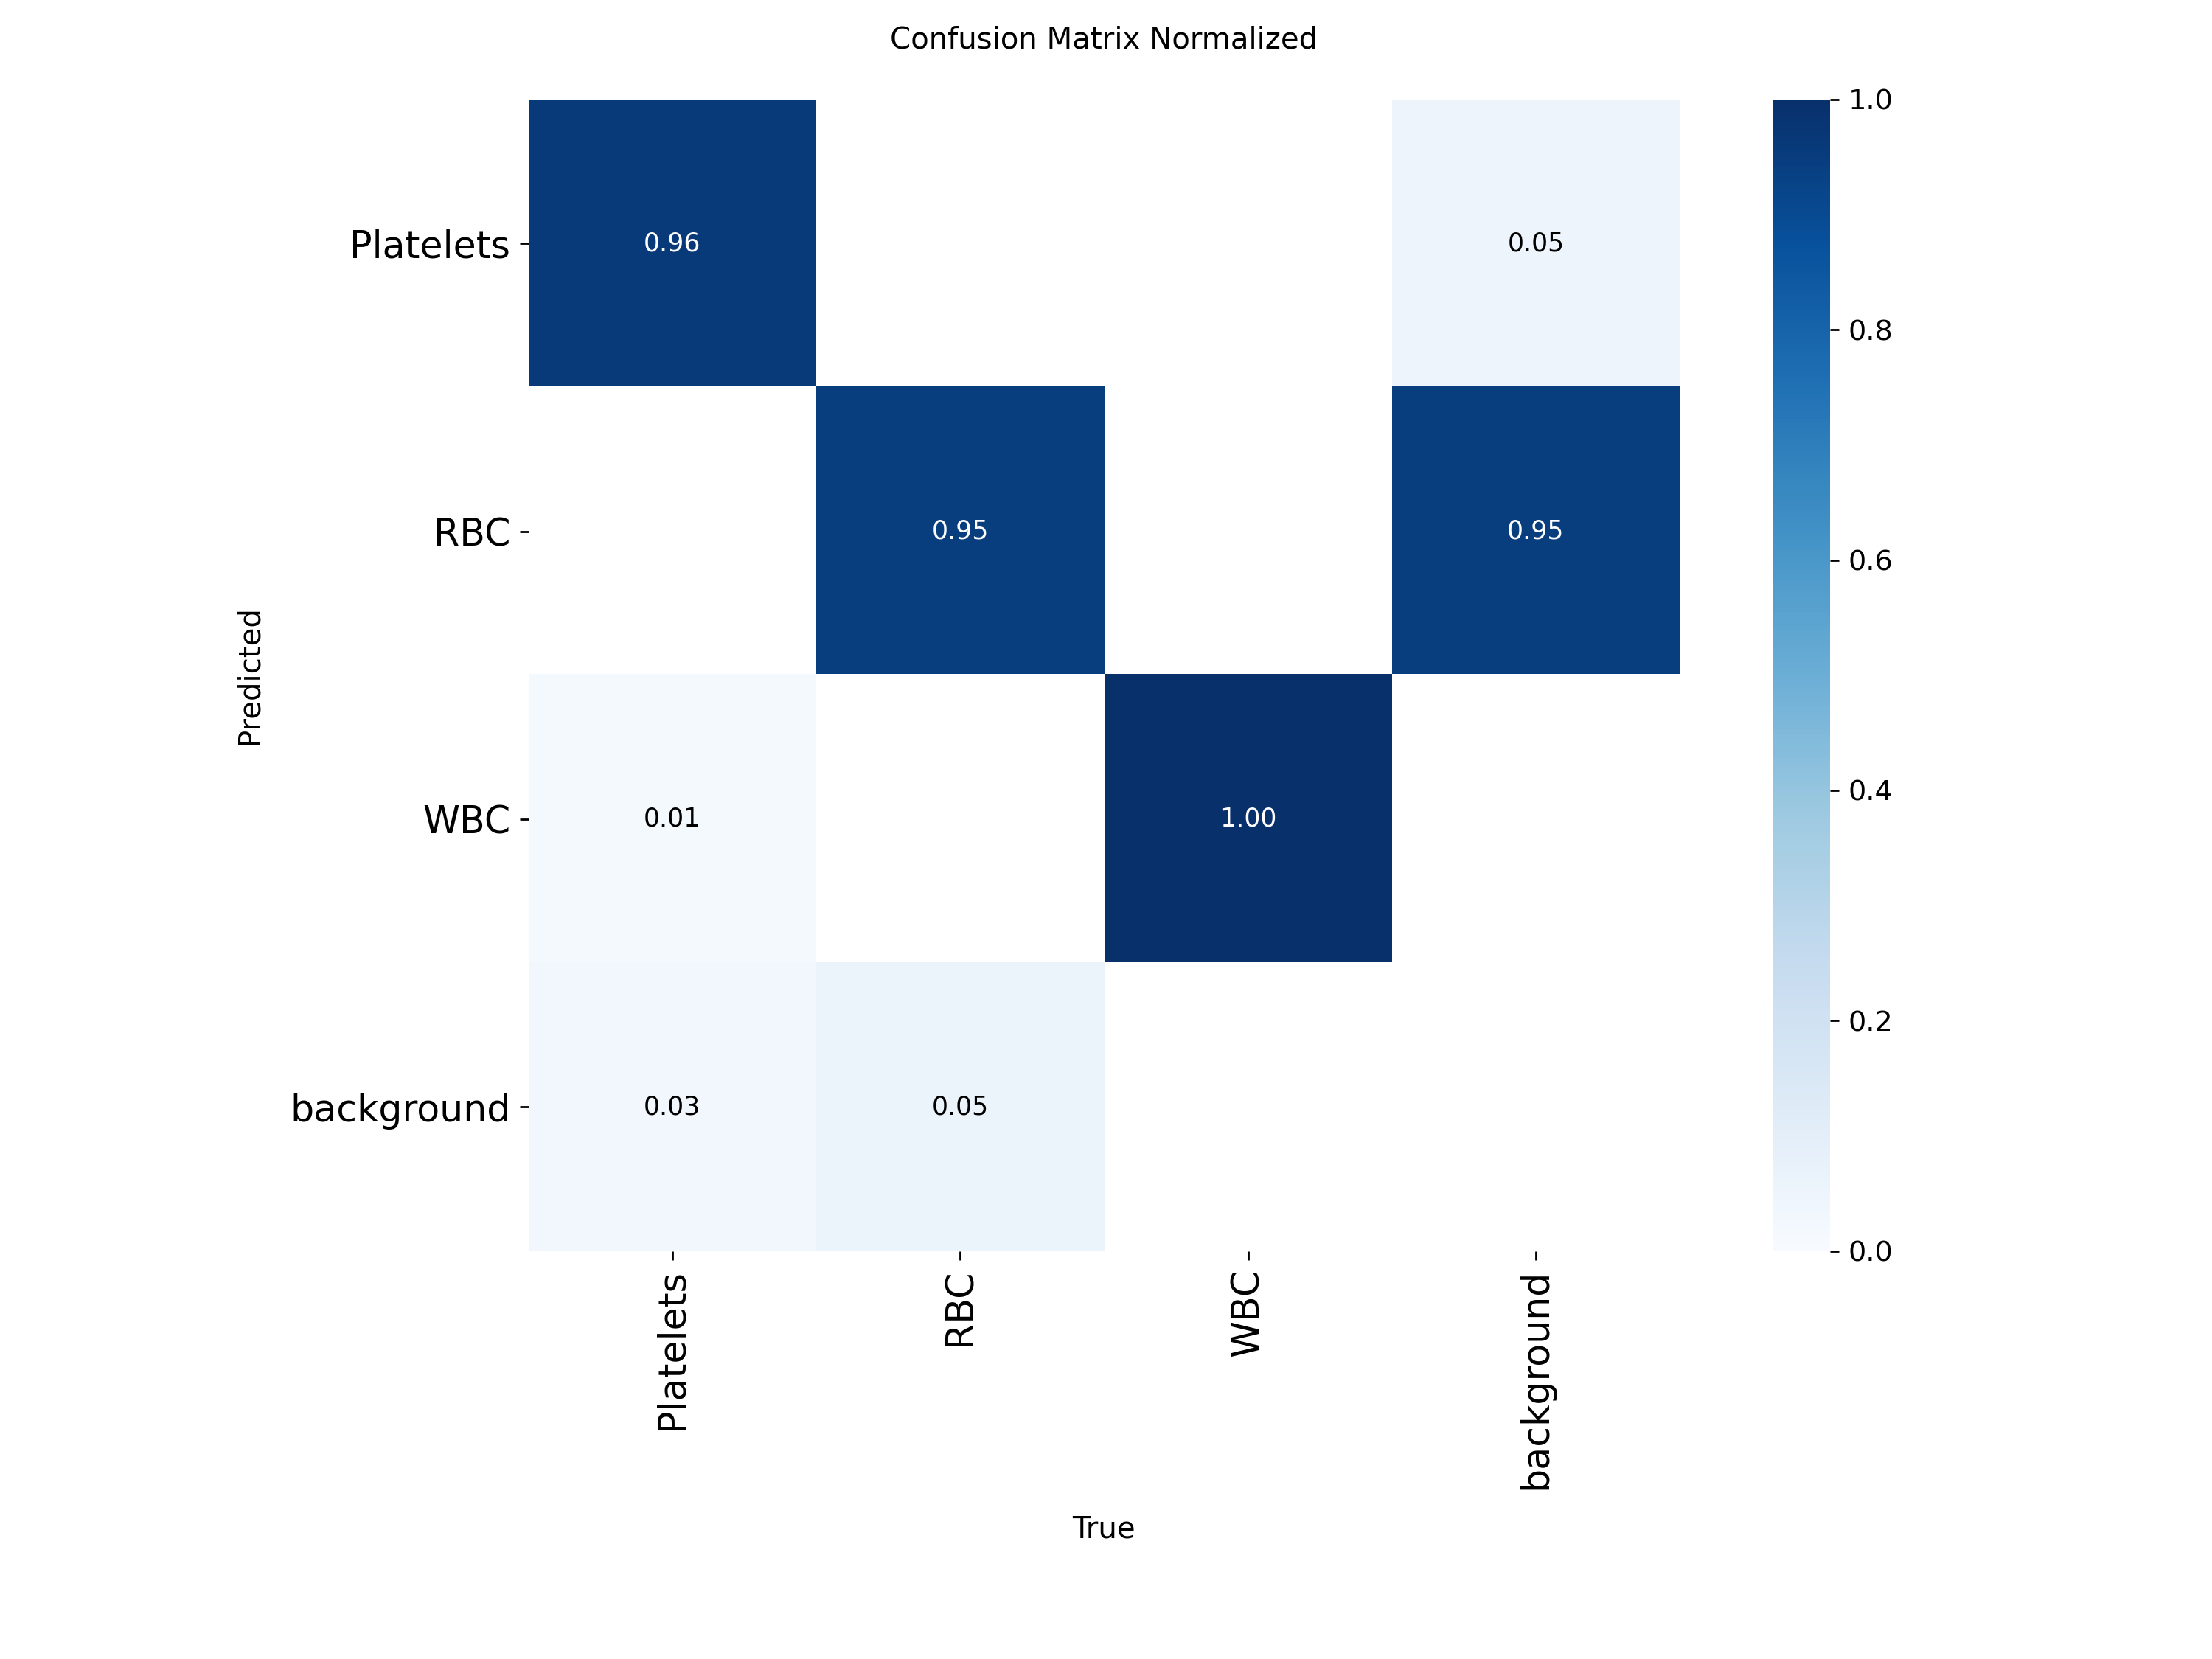

In [ ]:
IPyImage(filename=f'{HOME}/datasets/runs/detect/train/confusion_matrix_normalized.png', width=600)

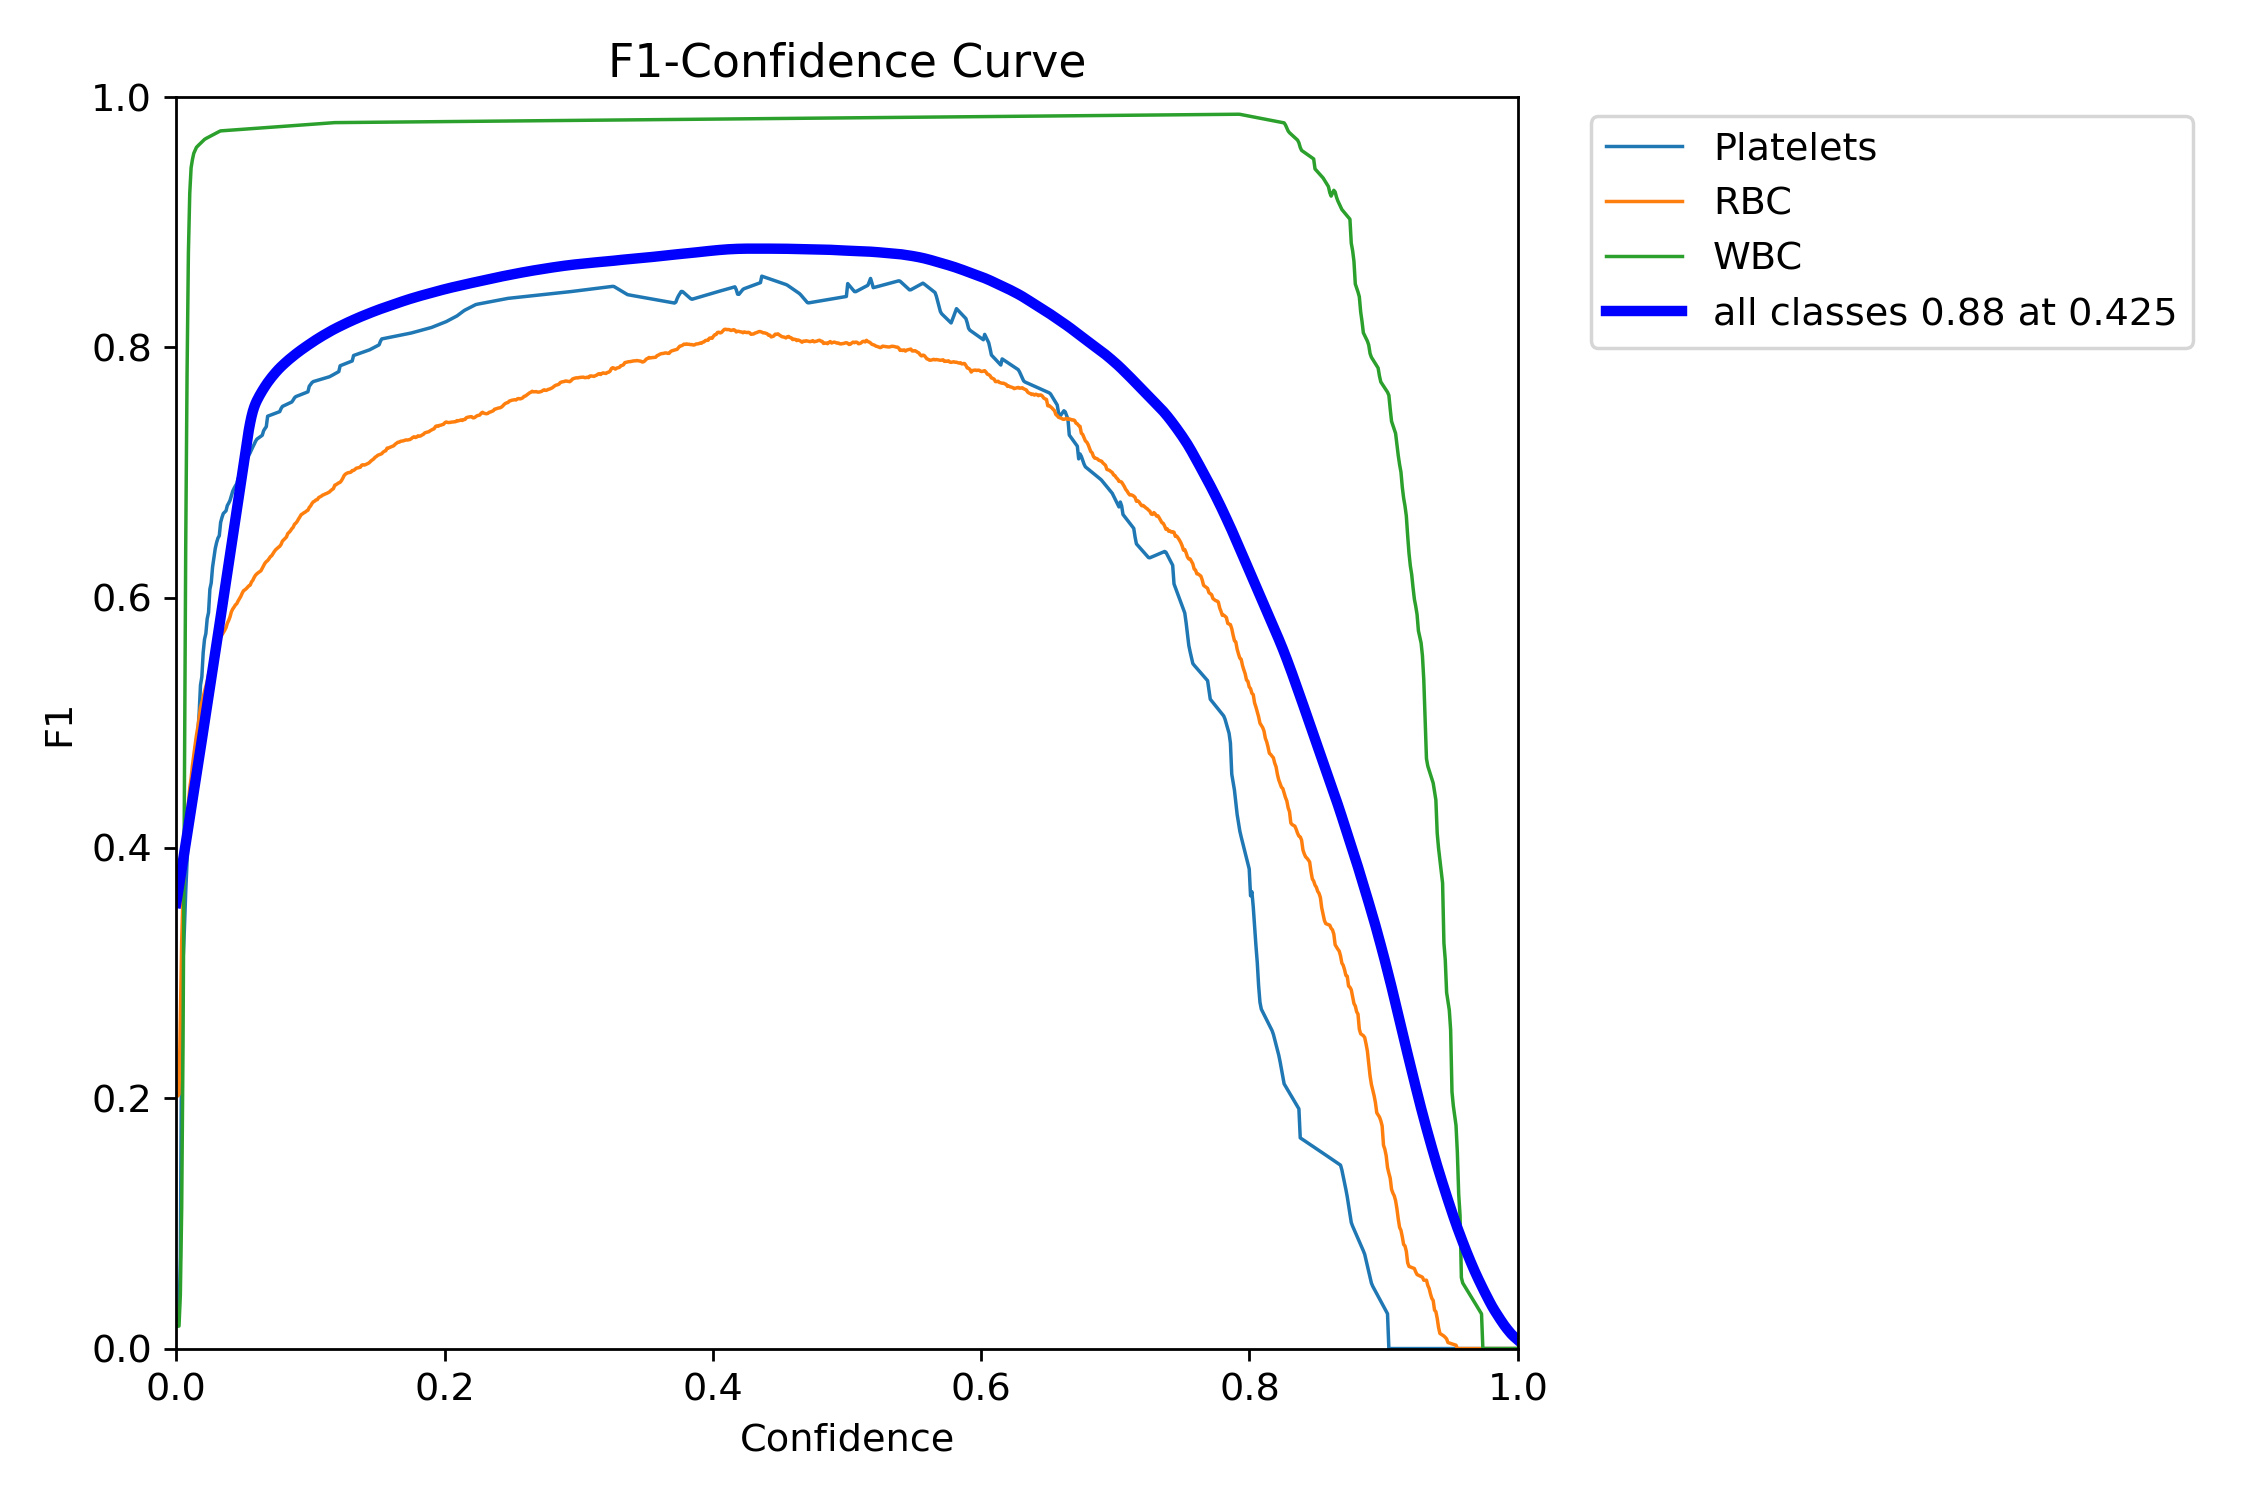

In [ ]:
IPyImage(filename=f'{HOME}/datasets/runs/detect/train/BoxF1_curve.png', width=600)

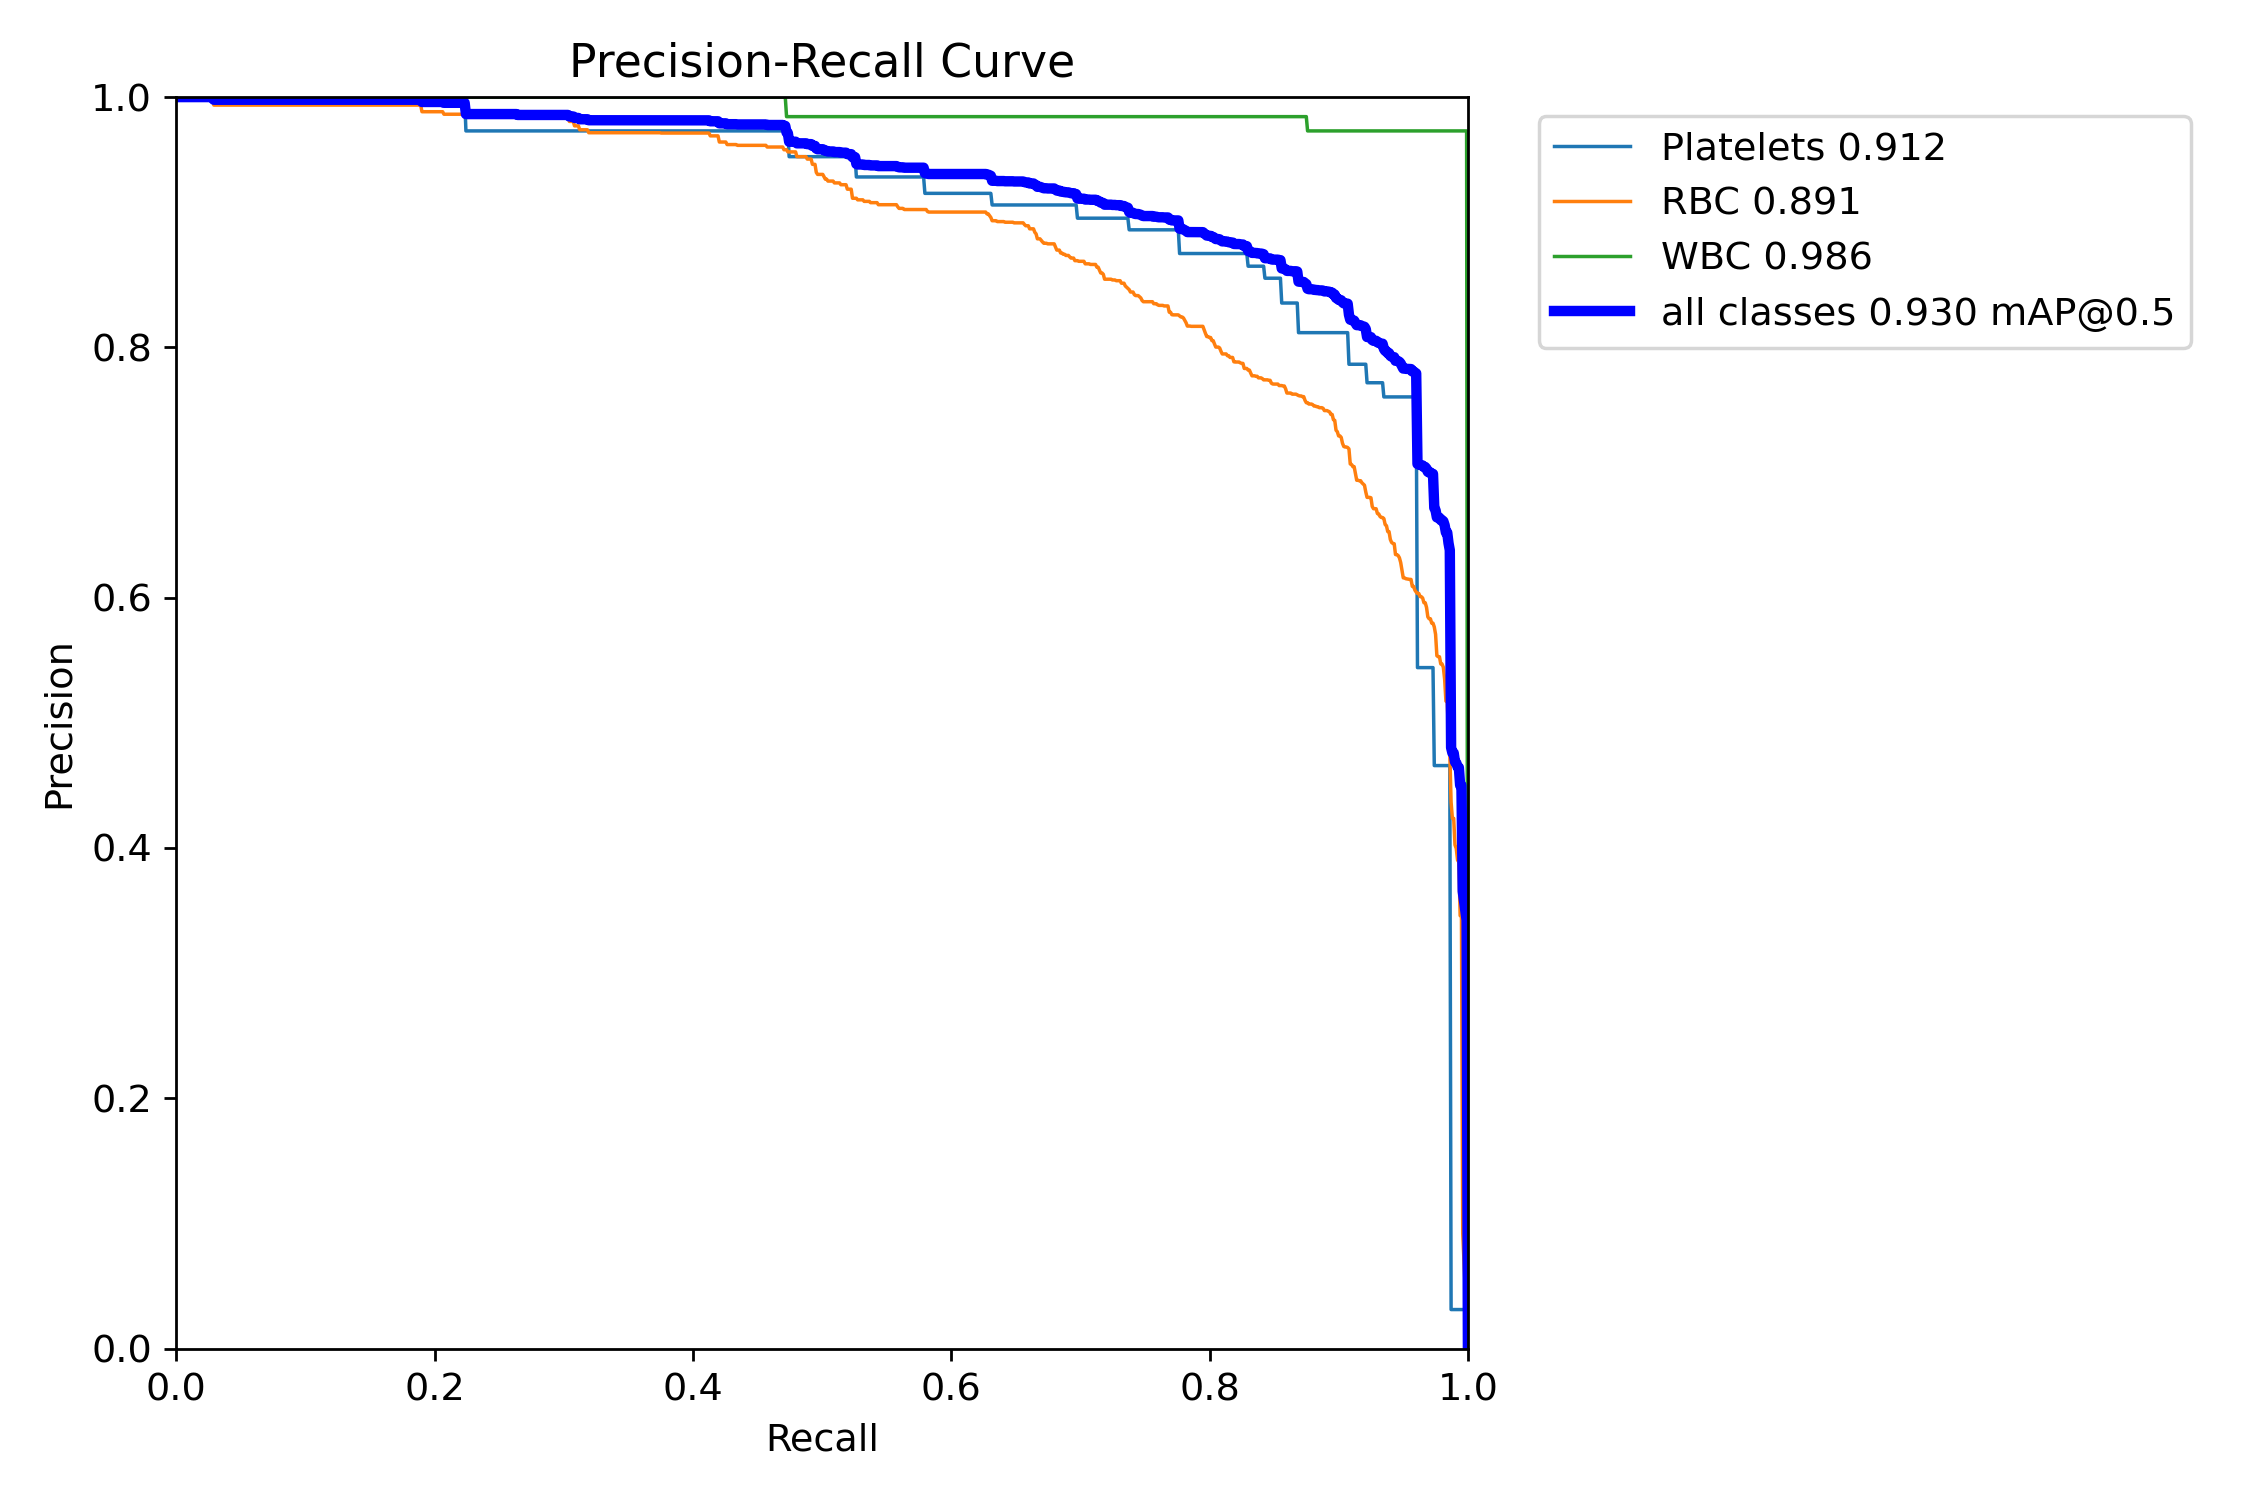

In [ ]:
IPyImage(filename=f'{HOME}/datasets/runs/detect/train/BoxPR_curve.png', width=600)

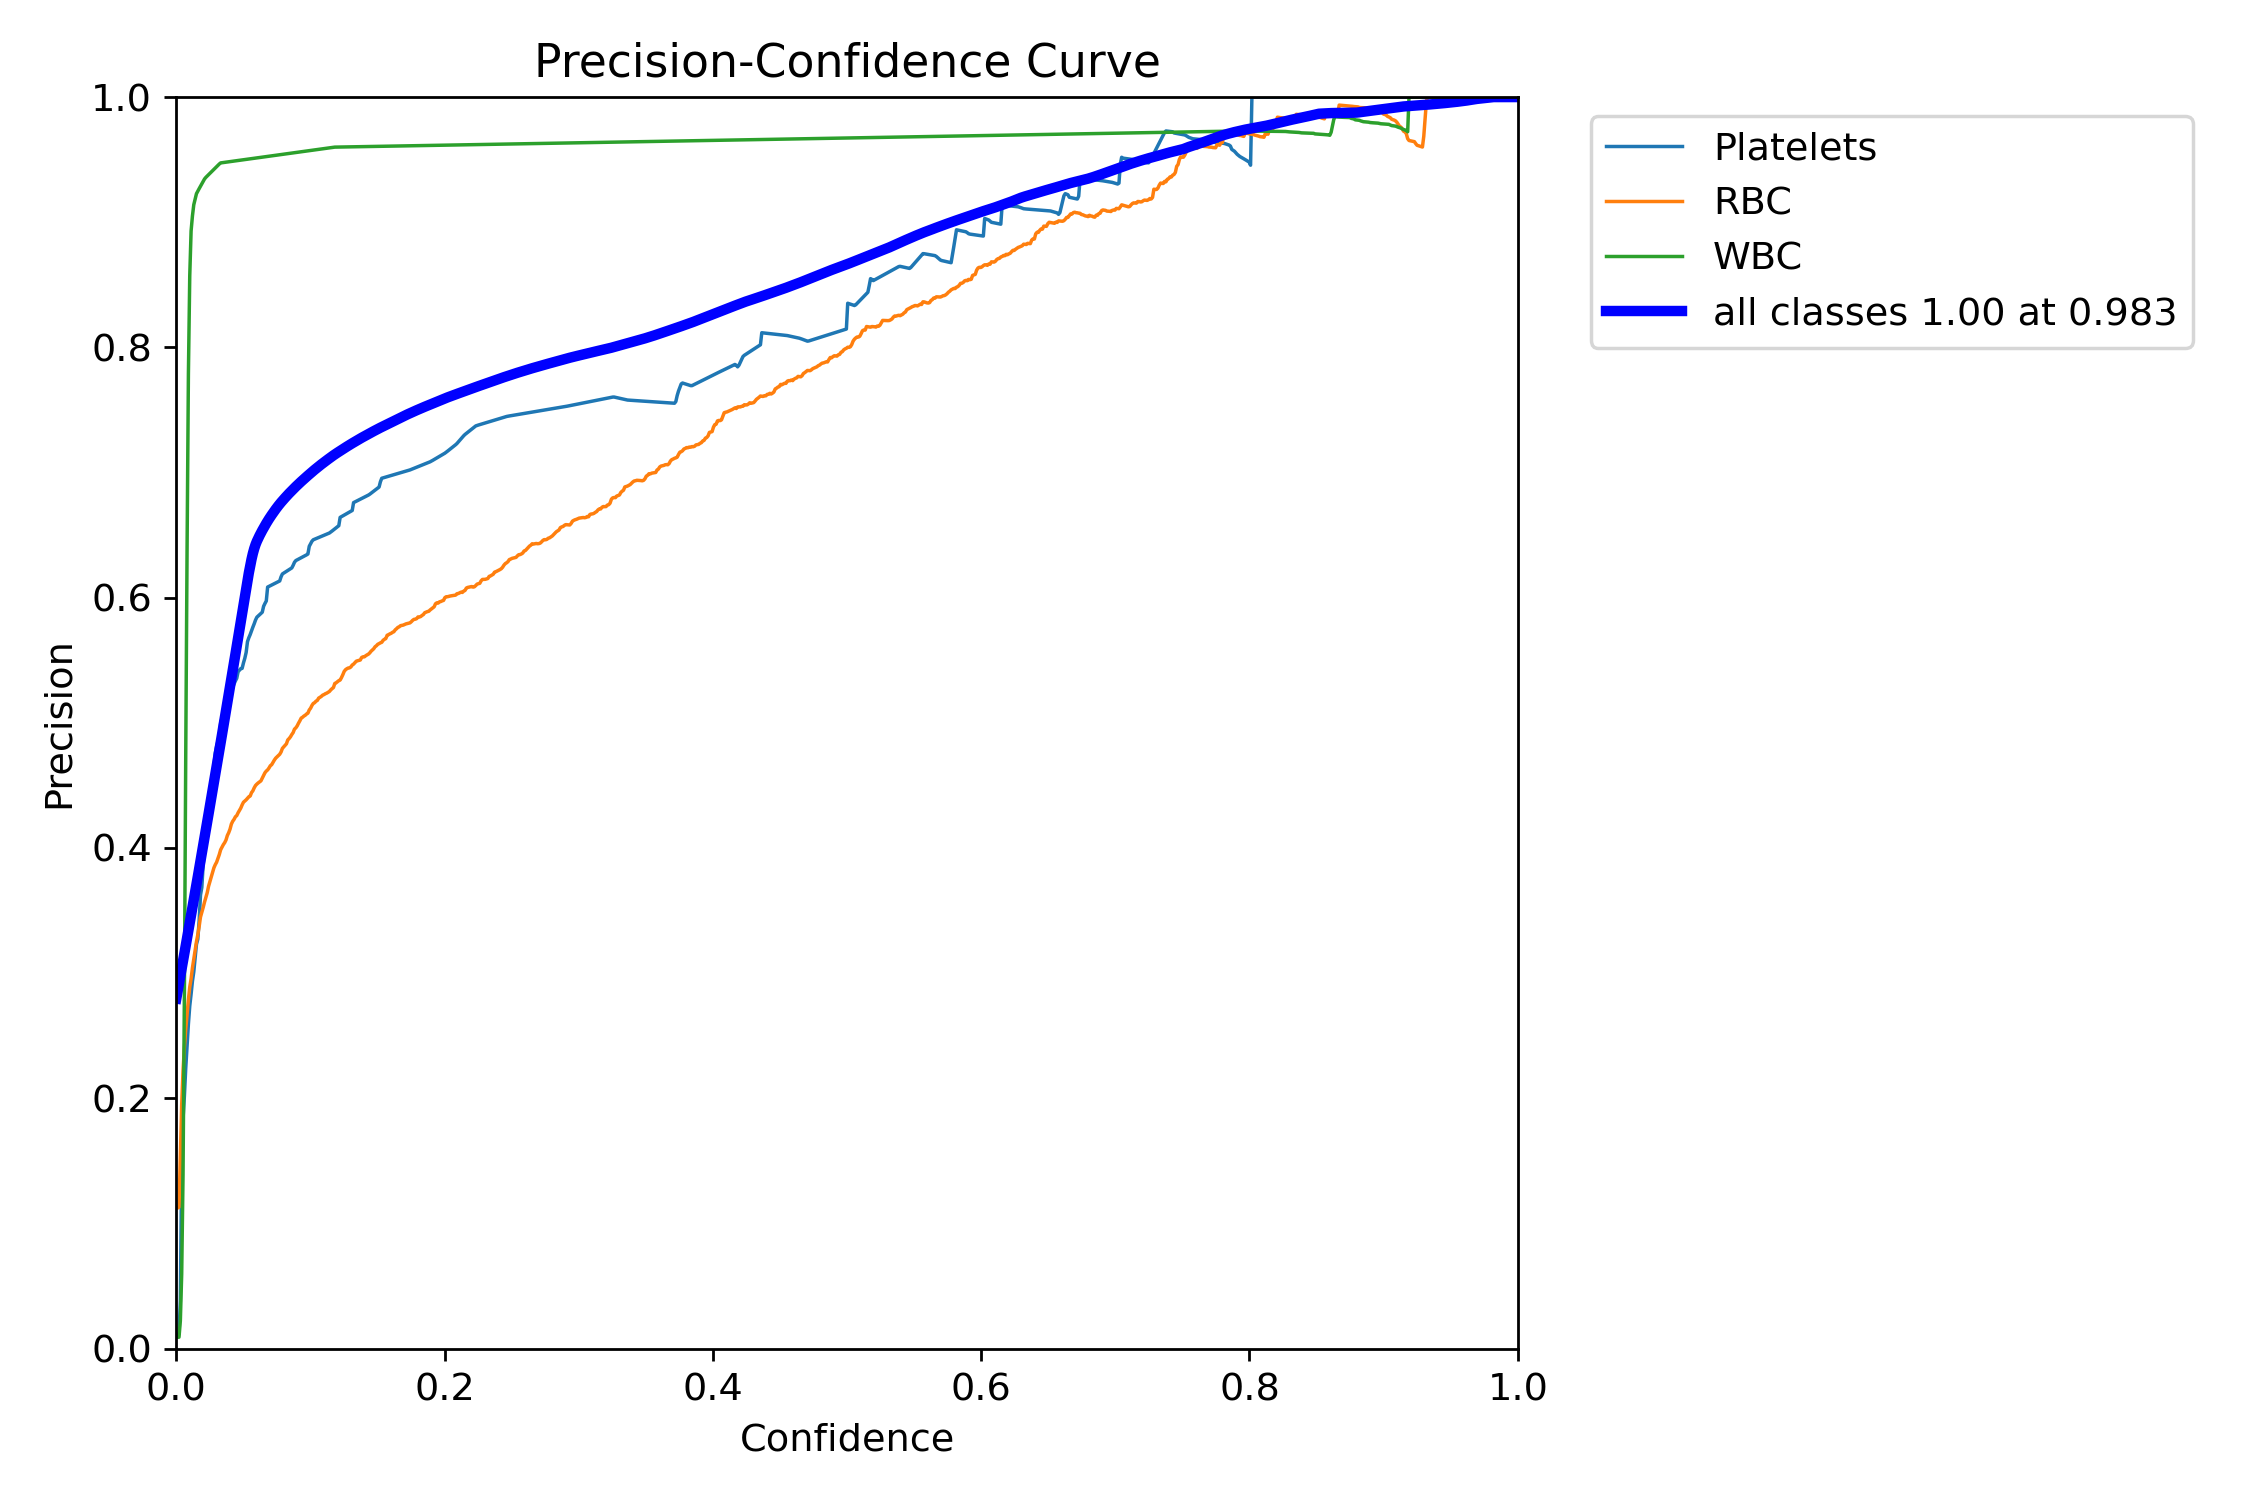

In [ ]:
IPyImage(filename=f'{HOME}/datasets/runs/detect/train/BoxP_curve.png', width=600)

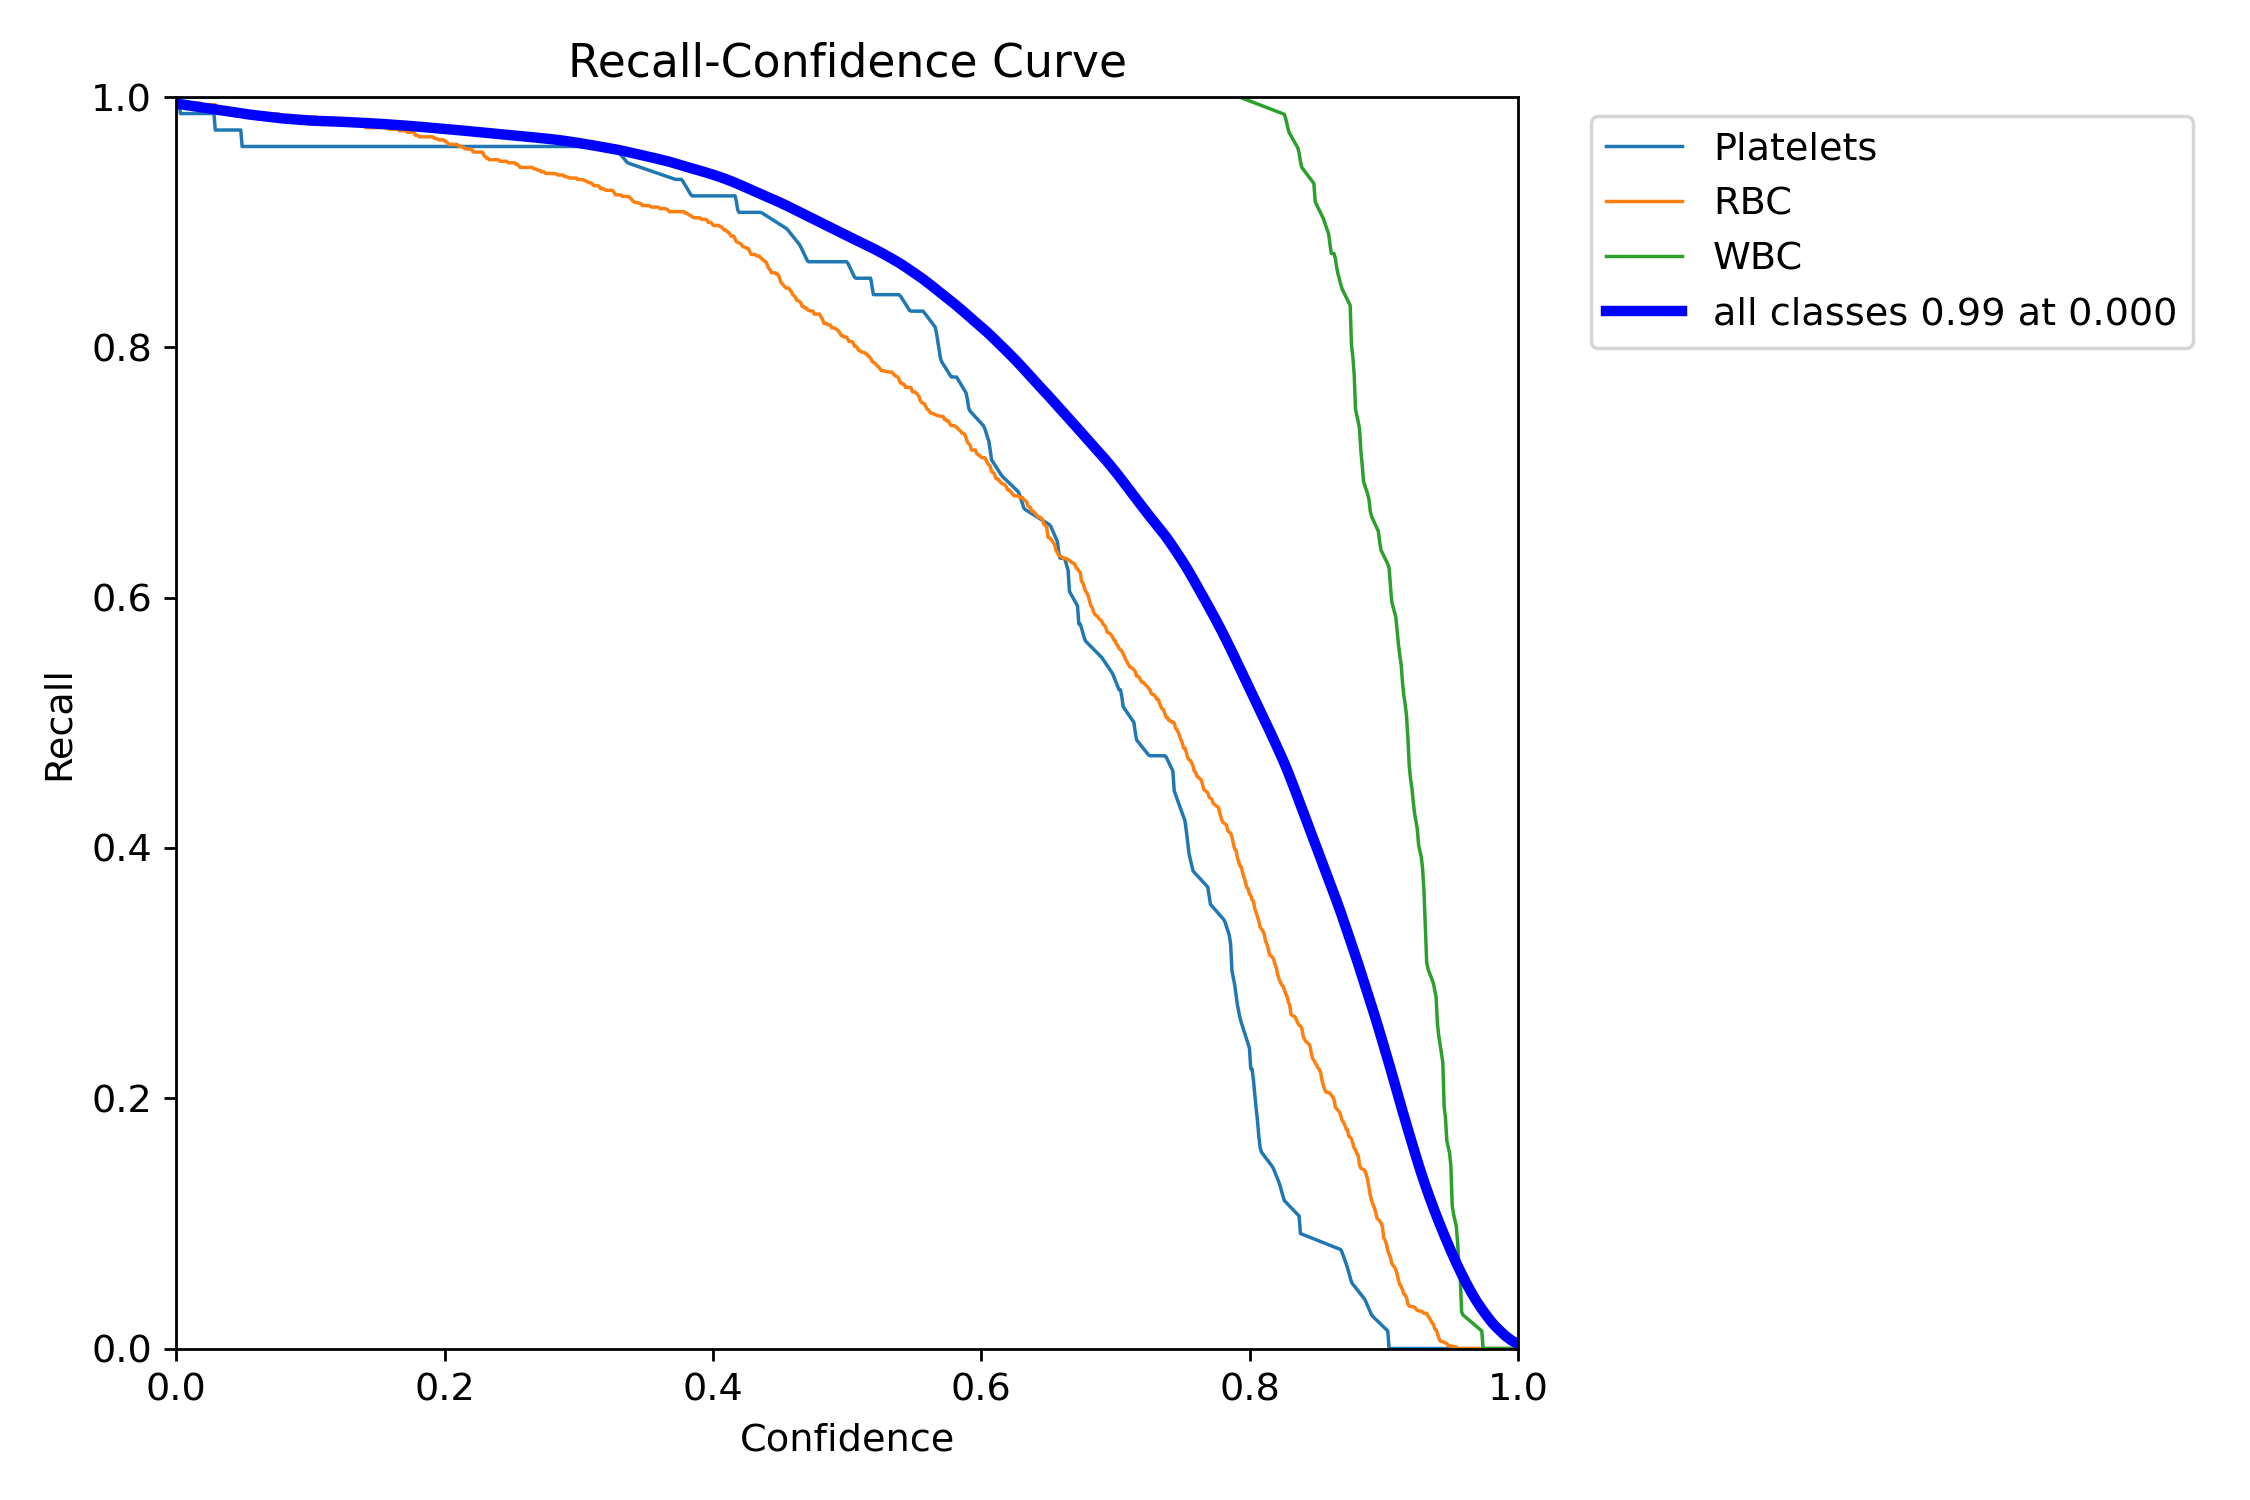

In [ ]:
IPyImage(filename=f'{HOME}/datasets/runs/detect/train/BoxR_curve.png', width=600)

In [ ]:
# -----UNCOMMENT THE CODE BELOW TO DOWNLOAD RESULTS LOCALLY-----
#!zip -r /content/file.zip /content/datasets

#from google.colab import files
#files.download("/content/file.zip")